### Data PreProcessing 

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50  ## the model will go throw all the dataset and back : forward and back 

In [4]:
dataset  = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle  = True , 
    image_size  = (IMAGE_SIZE, IMAGE_SIZE), 
    batch_size  = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names 

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

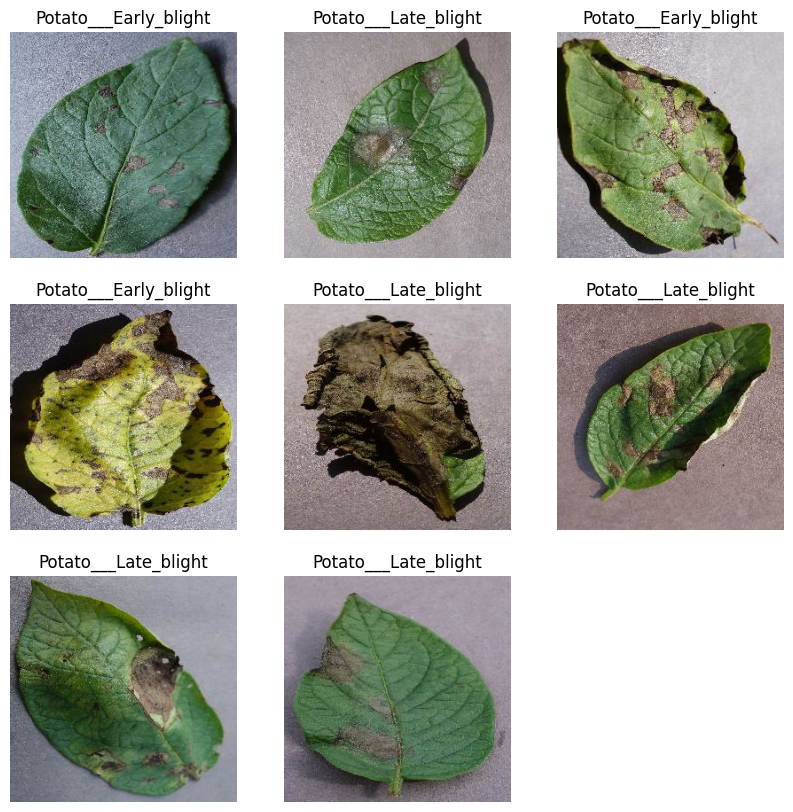

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
train_ds = dataset.take(54)
test_ds = dataset.skip(54)

In [8]:
val_ds = test_ds.take(6)

In [9]:
test_ds =  test_ds.skip(6)

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    ## shuffle the data size in a buffer have size of 10000, same seed == the same shuffled order of data
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
# prefetch : is for reducing the time of waiting the batchh being preprocced by the gpu to load another batch , so it works in the backgound 
# cache : is used to store dataset in the memory to stop counsuming the computations to go and preprocess all the images 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # autotune = let it decide how many batches to load to train
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    layers.experimental.preprocessing.Rescaling(1.0/255) 
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Model Building

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS) ## channels its used for colors : RGB = 3, for gray we use 1
n_classes  = 3
model  = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    ## filter  == kernel 
    ## each filter learn to detect a specific feature, the outputs of all filters called feature map that wiull be passed to the next Convolutional layer
    ## filters is used for detecting features in the image, it's a matrice , incrasing number of filters  = model can learn more + computation cost
    ## kernel_size is the dimention of the filter , a small kernel size captures finer details but larger one captures global things
    ## activation , is a math function that makes the network non-lineare, so it can learn complex patterns 
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    ## flaten layer used to convert the matrix output of features map to a one dimentional vector 
    layers.Flatten(),
    ## convolutional layers => fully connected layers 
    layers.Dense(64, activation= 'relu'),
    ## the final layer == output layers it has 3 neurons each one with a class
    ## we use softmax because it give sthe "probability" , so the values should be non negative and the sum of all the values should be = 1 = 100%
    layers.Dense(n_classes, activation = 'softmax')
])
model.build(input_shape = input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [17]:
## its used for configurating the model before training
model.compile(
    ## its a function/algorithm that modify n each epoch the weights and minimize the loss function, its optimize the model
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False), ## from_logits  = false is uses to told the loss function that the outputs not normalized, not being passed to a softmax function
    ## while training the model will monitoring the metrics : accuracy of the model to give right predictions 
    metrics  = ['accuracy']
)

In [18]:
history  = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size  = BATCH_SIZE,
    ## 0: delete all training outputs 1: show training progress for each epoch 2: display the training metrics for each epoch
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50


54/54 [==============================] - 91s 2s/step - loss: 0.8977 - accuracy: 0.4769 - val_loss: 0.8272 - val_accuracy: 0.5469
Epoch 2/50
54/54 [==============================] - 78s 1s/step - loss: 0.6995 - accuracy: 0.6777 - val_loss: 0.6967 - val_accuracy: 0.6510
Epoch 3/50
54/54 [==============================] - 84s 2s/step - loss: 0.5788 - accuracy: 0.7459 - val_loss: 0.4616 - val_accuracy: 0.7812
Epoch 4/50
54/54 [==============================] - 100s 2s/step - loss: 0.4348 - accuracy: 0.8281 - val_loss: 0.3307 - val_accuracy: 0.8490
Epoch 5/50
54/54 [==============================] - 88s 2s/step - loss: 0.3819 - accuracy: 0.8472 - val_loss: 0.3629 - val_accuracy: 0.8385
Epoch 6/50
54/54 [==============================] - 85s 2s/step - loss: 0.2657 - accuracy: 0.9010 - val_loss: 0.2353 - val_accuracy: 0.9062
Epoch 7/50
54/54 [==============================] - 90s 2s/step - loss: 0.2337 - accuracy: 0.9126 - val_loss: 0.2454 - val_accuracy: 0.8906
Epoch 8/50
54/54 

In [19]:
scores  = model.evaluate(test_ds)

8/8 [==============================] - 5s 301ms/step - loss: 0.1027 - accuracy: 0.9688


In [20]:
scores

[0.10273946821689606, 0.96875]

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
accuracy = history.history["accuracy"]
loss = history.history["loss"]
val_accuracy = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and validation Loss')

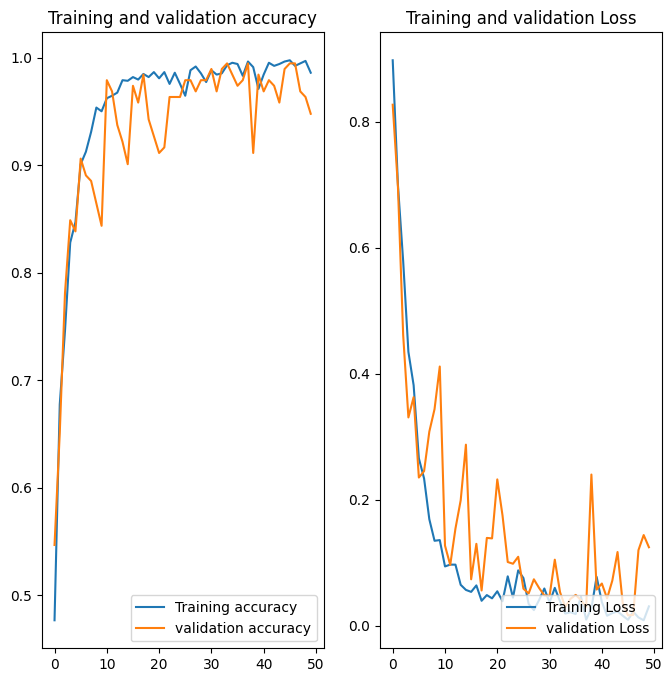

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
        # x axis         y axis
plt.plot(range(EPOCHS), accuracy, label = 'Training accuracy')
plt.plot(range(EPOCHS), val_accuracy, label = 'validation accuracy')
plt.legend(loc= 'lower right')
plt.title("Training and validation accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'validation Loss')
plt.legend(loc= 'lower right')
plt.title("Training and validation Loss")

Actual label : Potato___Early_blight
1/1 [==============================] - 3s 3s/step
Predicted Label : Potato___Early_blight


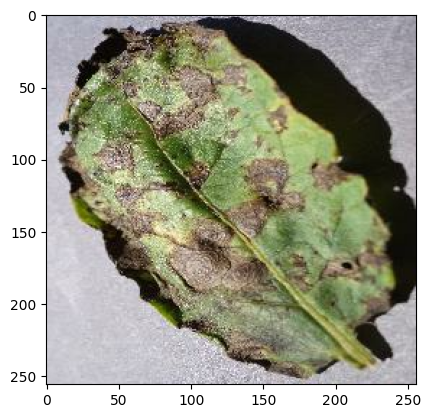

In [24]:
import numpy as np 
for image_batch, label_batch in test_ds.take(1):
  plt.imshow(image_batch[1].numpy().astype("uint8"))
  print("Actual label : " + class_names[label_batch[1]])

  batch_prediction = model.predict(image_batch)
  print("Predicted Label : " + class_names[np.argmax(batch_prediction[1])])

In [25]:
def predict(model, img):
    img_array  = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # create a batch of 1 image

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


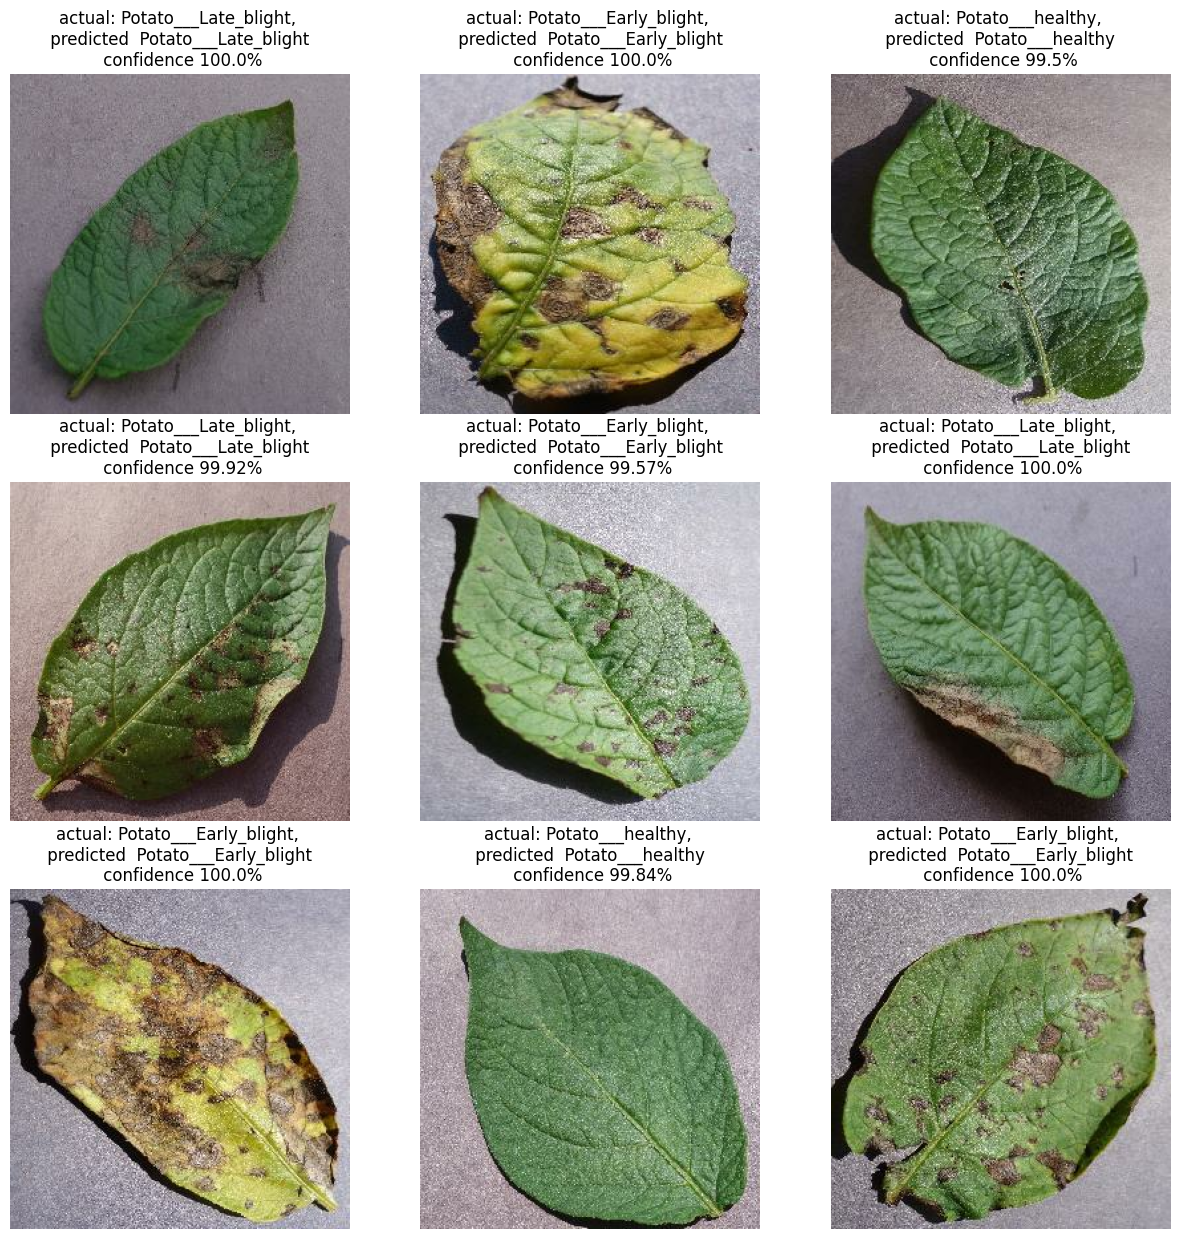

In [26]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"actual: {actual_class}, \n predicted  {predicted_class} \n confidence {confidence}%" )

In [27]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/12\assets


INFO:tensorflow:Assets written to: ./models/12\assets
